# Example `beacon_api_eth_v1_events_block` notebook with lazy querying
This notebook allows for setting a date range at the top to lazily query remote parquet files for `beacon_api_eth_v1_events_block` data using Polars LazyFrames execution engine. Requires polars greater than 0.20.18. [Link to google colab notebook](https://colab.research.google.com/drive/1tDWpboS3j9r2_WwYbJy5thPAkKxtmnSP#scrollTo=G3i3tgD0g1ev)

```bash
pip install polars matplotlib
```

In [2]:
import polars as pl
from datetime import datetime, timedelta

In [3]:
# start and end date range
start_date = datetime(2024, 4, 1)
end_date = datetime(2024, 4, 3)

# base url endpiont. Replace this with other tables to explore different datasets
base_url = "https://data.ethpandaops.io/xatu/mainnet/databases/default/beacon_api_eth_v1_events_block/"

# list comprehension to generate endpoints
parquet_urls = []
parquet_urls = [
    f"{base_url}{date.year}/{date.month}/{date.day}.parquet"
    for date in (
        start_date + timedelta(days=n) for n in range((end_date - start_date).days + 1)
    )
]

In [13]:
# Create a list of Lazy DataFrames for each Parquet file
lazy_dfs = [pl.scan_parquet(file) for file in parquet_urls]

# Concatenate all Lazy DataFrames into one
concat_lazy_dfs = pl.concat(lazy_dfs)

## Perform Analysis
Calculate the median `propagation_slot_start_diff` per `slot_start_date_time` on the combined dataset.

In [14]:
import matplotlib.pyplot as plt

In [21]:
# Group by slot_start_date_time and calculate median propagation_slot_start_diff
grouped = (
    concat_lazy_dfs.group_by("slot_start_date_time")
    .agg(pl.col("propagation_slot_start_diff").median())
    .with_columns(pl.from_epoch("slot_start_date_time").alias("slot_start_date_time"))
    .sort(by="slot_start_date_time")
    .collect()
)

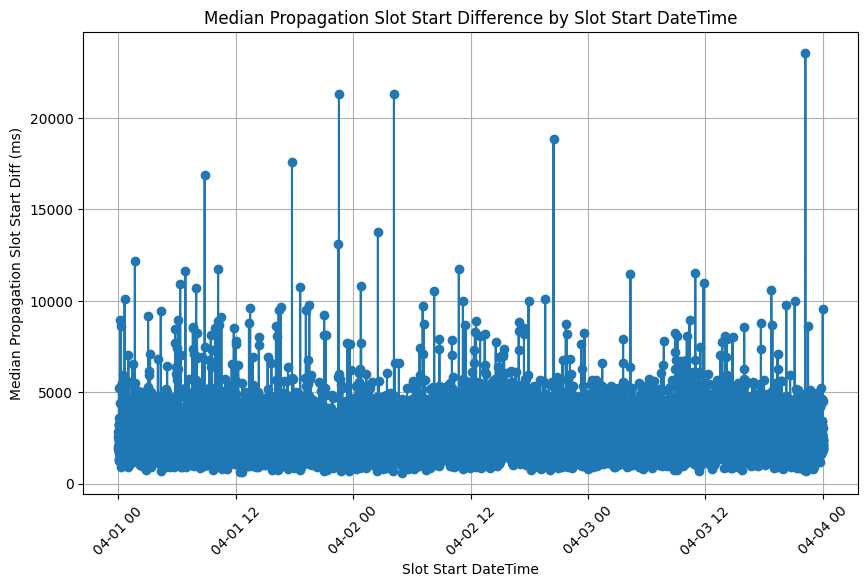

In [22]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    grouped["slot_start_date_time"], grouped["propagation_slot_start_diff"], marker="o"
)
plt.title("Median Propagation Slot Start Difference by Slot Start DateTime")
plt.xlabel("Slot Start DateTime")
plt.ylabel("Median Propagation Slot Start Diff (ms)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()